In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn


class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, nhead):
        super(TransformerModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim

        # Define a linear layer to transform input to embedding dimension
        self.input_linear = nn.Linear(input_dim, hidden_dim)
        
        # Positional encoding to add position information to the input embeddings
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, hidden_dim))

        # Define the Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Define the output linear layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        
        # Apply linear transformation to input to get embeddings
        x = self.input_linear(x)
        
        # Add positional encoding
        seq_len = x.size(1)
        x += self.positional_encoding[:, :seq_len, :]

        # Transformer expects input of shape [seq_len, batch_size, hidden_dim]
        x = x.transpose(0, 1)
        
        # Pass through the transformer encoder
        transformer_out = self.transformer_encoder(x)
        
        # Select the last time step's output
        last_time_step = transformer_out[-1, :, :]

        # Pass through the final linear layer to get predictions
        y_pred = self.linear(last_time_step)
        return y_pred


In [34]:
# Initialisation du modèle
input_dim = 3
hidden_dim = 64
output_dim = 1
num_layers = 3
nhead = 8

model = TransformerModel(input_dim, hidden_dim, output_dim, num_layers, nhead)

# Préparation des données d'entrée
x = torch.randn(32, 20, input_dim)  # batch_size = 32, seq_len = 20, input_dim = 3

# Passage des données à travers le modèle
y_pred = model(x)

# Vérification de la sortie
print(y_pred.shape)  # Doit afficher torch.Size([32, 1]), correspondant à [batch_size, output_dim]

torch.Size([32, 1])


Text(0, 0.5, 'Value')

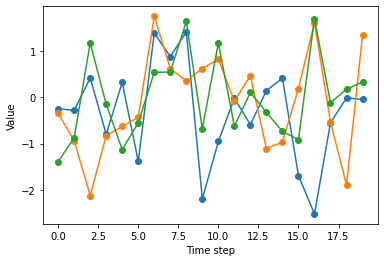

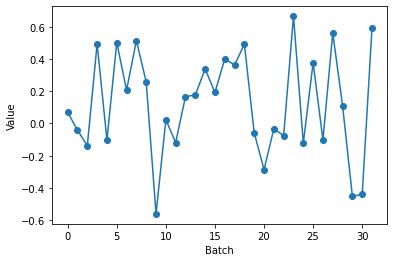

In [36]:
#plot the input data x 
fig, ax = plt.subplots()
c = ax.plot(x[0, :, :].detach().numpy(), '-o')
ax.set_xlabel('Time step')
ax.set_ylabel('Value')

#plot the output data y_pred
fig, ax = plt.subplots()
c = ax.plot(y_pred.detach().numpy(), '-o')
ax.set_xlabel('Batch')
ax.set_ylabel('Value')


### Modification to get the attention mask

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super(CustomTransformerEncoderLayer, self).__init__(*args, **kwargs)
        self.self_attn_weights = None

    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[0]
        self.self_attn_weights = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[1]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, nhead):
        super(TransformerModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim

        # Define a linear layer to transform input to embedding dimension
        self.input_linear = nn.Linear(input_dim, hidden_dim)
        
        # Positional encoding to add position information to the input embeddings
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, hidden_dim))

        # Define the Transformer encoder layer
        encoder_layer = CustomTransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Define the output linear layer
        self.linear = nn.Linear(hidden_dim, output_dim)
        
        self.attention_weights = None

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        
        # Apply linear transformation to input to get embeddings
        x = self.input_linear(x)
        
        # Add positional encoding
        seq_len = x.size(1)
        x += self.positional_encoding[:, :seq_len, :]

        # Transformer expects input of shape [seq_len, batch_size, hidden_dim]
        x = x.transpose(0, 1)
        
        # Pass through the transformer encoder
        transformer_out = self.transformer_encoder(x)
        
        # Select the last time step's output
        last_time_step = transformer_out[-1, :, :]

        # Pass through the final linear layer to get predictions
        y_pred = self.linear(last_time_step)
        
        # Store attention weights
        self.attention_weights = [layer.self_attn_weights for layer in self.transformer_encoder.layers]
        
        return y_pred

    def get_attention_weights(self):
        return self.attention_weights




In [54]:
# Example usage
input_dim = 3
hidden_dim = 64
output_dim = 1
num_layers = 2
nhead = 1

model = TransformerModel(input_dim, hidden_dim, output_dim, num_layers, nhead)
# Dummy input
x = torch.rand(32, 20, input_dim)  # batch_size=32, seq_len=100, input_dim=10
y_pred = model(x)

# Get attention weights
attention_weights = model.get_attention_weights()


c:\Users\Mehdi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [59]:
print(y_pred.shape)  # Doit afficher torch.Size([32, 1]), correspondant à [batch_size, output_dim]
print(x.shape) # Doit afficher torch.Size([32, 20, 3]), correspondant à [batch_size, seq_len, input_dim]
print(len(attention_weights))  # Doit afficher 2, correspondant au nombre de couches dans le modèle
print(attention_weights[-1].shape)  # Doit afficher torch.Size([20, 32, 32]), correspondant à [seq_len, batch_size, batch_size]

torch.Size([32, 1])
torch.Size([32, 20, 3])
2
torch.Size([32, 20, 20])


Text(0, 0.5, 'Value')

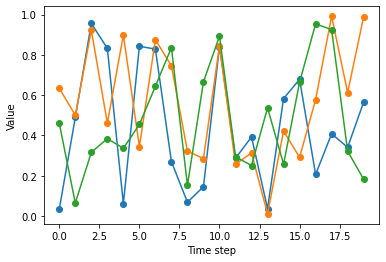

In [56]:
#plot the input data x 
fig, ax = plt.subplots()
c = ax.plot(x[0, :, :].detach().numpy(), '-o')
ax.set_xlabel('Time step')
ax.set_ylabel('Value')

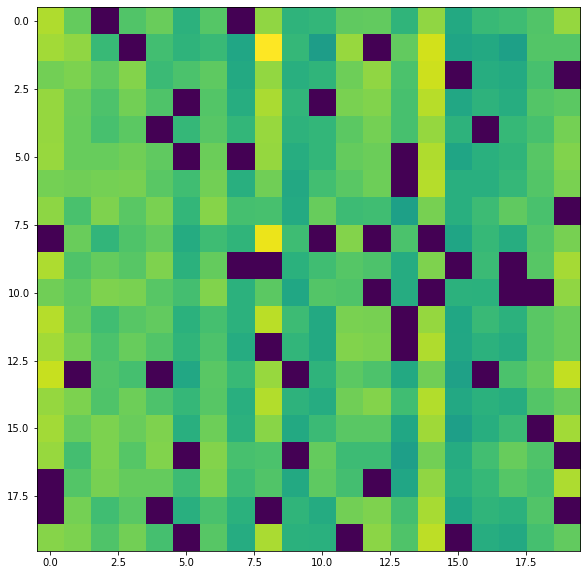

In [62]:
#display the last attention weights 
'''
Le masque d'attention est une matrice carrée où chaque élément [i, j] indique si l'attention du token i doit prendre en compte le token j 
lors du calcul de l'attention. Ainsi, pour une séquence de longueur 20, le masque d'attention aura des dimensions 20 x 20 pour chaque élément du lot.
Deuxième seq_len (20) : Correspond à la dimension des tokens de la séquence pour lesquels l'attention est calculée (tokens de sortie).
Troisième seq_len (20) : Correspond à la dimension des tokens de la séquence qui sont pris en compte pour le calcul de l'attention (tokens d'entrée).
'''
fig, ax = plt.subplots(figsize=(10, 10))
c = ax.imshow(attention_weights[-1].detach().numpy()[0, :, :])